# IAM Writer Recognition

This notebook is pretty much a translation of the "[handwriting_recognition](https://github.com/priya-dwivedi/Deep-Learning/tree/master/handwriting_recognition)" notebook by [Priyanka Dwivedi](https://github.com/priya-dwivedi). I have chosen to rewrite it differently here as to make it easier to follow, for my own better understanding, and for others who wish to learn from it.

The goal of the notebook is to use the method explained in the paper [DeepWriter: A Multi-Stream Deep CNN for Text-independent Writer Identification](https://arxiv.org/abs/1606.06472) to identify the writer (author) of a text based on their writing styles. To do so, we'll use the [IAM Handwriting Database](http://www.fki.inf.unibe.ch/databases/iam-handwriting-database/download-the-iam-handwriting-database). Please make sure the dataset has been correctly set up before executing the notebook as outlined [here](https://github.com/diegocasmo/iam_writer_recognition/tree/master/data).

# Reading The Dataset

The first step is to create a dictionary which will map each form ID (sentence) to a writer. This information is available in the ``forms.txt`` file, where each line (except for the first 16 lines, which are documentation) defines the form ID at index ``0``, and its writer at index ``1``.

In [1]:
# Create a dictionary to store each form ID and its writer
import os
from itertools import islice

form_writer = {}
forms_file_path = "../data/forms.txt"
with open(forms_file_path) as f:
    for line in islice(f, 16, None):
        line_list = line.split(' ')
        form_id = line_list[0]
        writer = line_list[1]
        form_writer[form_id] = writer

Visualize dictionary (as array for simplicity):

In [2]:
list(form_writer.items())[0:5]
print("Number of form-writer pairs:", len(form_writer))
print(list(form_writer.items())[0:5])
print("Sample form-writer mappings:", list(form_writer.items())[:5])

Number of form-writer pairs: 1539
[('a01-000u', '000'), ('a01-000x', '001'), ('a01-003', '002'), ('a01-003u', '000'), ('a01-003x', '003')]
Sample form-writer mappings: [('a01-000u', '000'), ('a01-000x', '001'), ('a01-003', '002'), ('a01-003u', '000'), ('a01-003x', '003')]


For efficiency reasons,  we'll select the 50 most common writers from the dictionary we have created, and the rest of the notebook will only focus on them (as opposed to using the 221 authors present in the dataset).

In [3]:
# Select the 50 most common writer

from collections import Counter

top_writers = []
num_writers = 50
writers_counter = Counter(form_writer.values())
for writer_id,_ in writers_counter.most_common(num_writers):
    top_writers.append(writer_id)

Visualize the writer id of the top 50 writers:

In [4]:
print("Top writer IDs:", top_writers[0:5])
print(top_writers[0:5])

Top writer IDs: ['000', '150', '151', '152', '153']
['000', '150', '151', '152', '153']


From the 50 most common writers we have selected, we'll now need to select the forms (sentences) they have written:

In [5]:
top_forms = []
for form_id, author_id in form_writer.items():
    if author_id in top_writers:
        top_forms.append(form_id)

Visualize the form id of the top 50 writers:

In [6]:
print("Number of top forms:", len(top_forms))
print("Sample form IDs:", top_forms[:5])
print(top_forms[0:5])

Number of top forms: 452
Sample form IDs: ['a01-000u', 'a01-003u', 'a01-007u', 'a01-011u', 'a01-014u']
['a01-000u', 'a01-003u', 'a01-007u', 'a01-011u', 'a01-014u']


Create a temp directory which contains only the sentences of the forms selected above:

In [7]:
import os
import glob
import shutil

# Create temp directory to save writers' forms in (assumes files have already been copied if the directory exists)
temp_sentences_path = "../data/temp_sentences"
if not os.path.exists(temp_sentences_path):
    os.makedirs(temp_sentences_path)

# Debugging Line 4: Check if 'top_forms' is correctly set
print(f"Top Forms: {top_forms}")

original_sentences_path = os.path.join("..", "data", "sentences", "*", "*", "*.png")

# Debugging Line 5: Verify the Paths
print("Files found:", glob.glob(original_sentences_path)[:5])

for file_path in glob.glob(original_sentences_path):
    image_name = file_path.split(os.path.sep)[-1]  # Use os.path.sep for cross-platform compatibility
    form_id = image_name.split('-')[0] + '-' + image_name.split('-')[1]

    if form_id in top_forms:
        # Debugging Line 6: Check if Files are Copied
        print(f"Copying file {file_path} to {temp_sentences_path}/{image_name}")
        try:
            shutil.copy(file_path, os.path.join(temp_sentences_path, image_name))
        except Exception as e:
            print(f"Failed to copy {file_path}. Error: {e}")


Top Forms: ['a01-000u', 'a01-003u', 'a01-007u', 'a01-011u', 'a01-014u', 'a01-020u', 'a01-026u', 'a01-030u', 'a01-043u', 'a01-049u', 'a01-049x', 'a01-053u', 'a01-058u', 'a01-063u', 'a01-068u', 'a01-072u', 'a01-077u', 'a01-082u', 'a01-087u', 'a01-091u', 'a01-096u', 'a01-102u', 'a01-107u', 'a01-113u', 'a01-117u', 'a01-122u', 'a01-128u', 'a01-132u', 'a01-132x', 'a02-017', 'a02-020', 'a02-024', 'a02-027', 'a02-032', 'a02-037', 'a02-042', 'a02-090', 'a02-093', 'a02-098', 'a02-102', 'a02-106', 'a02-111', 'a02-124', 'a03-047', 'a03-050', 'a03-071', 'a03-073', 'a03-080', 'a03-089', 'a05-000', 'a05-013', 'a05-017', 'a05-022', 'a05-025', 'a05-029', 'a05-039', 'a05-044', 'a05-048', 'a05-053', 'a05-058', 'a05-062', 'a05-069', 'a05-073', 'a05-080', 'a05-084', 'a05-089', 'a05-094', 'a05-099', 'a05-104', 'a05-108', 'a05-113', 'a05-116', 'a05-121', 'a05-125', 'a06-124', 'a06-134', 'a06-141', 'a06-147', 'a06-157', 'b05-055', 'b05-058', 'b05-062', 'b05-067', 'b05-071', 'b06-000', 'b06-008', 'b06-012', 'b

Copying file ..\data\sentences\a01\a01-049x\a01-049x-s01-00.png to ../data/temp_sentences/a01-049x-s01-00.png
Copying file ..\data\sentences\a01\a01-049x\a01-049x-s01-01.png to ../data/temp_sentences/a01-049x-s01-01.png
Copying file ..\data\sentences\a01\a01-049x\a01-049x-s01-02.png to ../data/temp_sentences/a01-049x-s01-02.png
Copying file ..\data\sentences\a01\a01-049x\a01-049x-s01-03.png to ../data/temp_sentences/a01-049x-s01-03.png
Copying file ..\data\sentences\a01\a01-049x\a01-049x-s02-00.png to ../data/temp_sentences/a01-049x-s02-00.png
Copying file ..\data\sentences\a01\a01-049x\a01-049x-s02-01.png to ../data/temp_sentences/a01-049x-s02-01.png
Copying file ..\data\sentences\a01\a01-049x\a01-049x-s02-02.png to ../data/temp_sentences/a01-049x-s02-02.png
Copying file ..\data\sentences\a01\a01-053u\a01-053u-s00-00.png to ../data/temp_sentences/a01-053u-s00-00.png
Copying file ..\data\sentences\a01\a01-053u\a01-053u-s00-01.png to ../data/temp_sentences/a01-053u-s00-01.png
Copying fi

Copying file ..\data\sentences\a01\a01-102u\a01-102u-s00-02.png to ../data/temp_sentences/a01-102u-s00-02.png
Copying file ..\data\sentences\a01\a01-102u\a01-102u-s00-03.png to ../data/temp_sentences/a01-102u-s00-03.png
Copying file ..\data\sentences\a01\a01-102u\a01-102u-s01-00.png to ../data/temp_sentences/a01-102u-s01-00.png
Copying file ..\data\sentences\a01\a01-102u\a01-102u-s02-00.png to ../data/temp_sentences/a01-102u-s02-00.png
Copying file ..\data\sentences\a01\a01-102u\a01-102u-s02-01.png to ../data/temp_sentences/a01-102u-s02-01.png
Copying file ..\data\sentences\a01\a01-102u\a01-102u-s02-02.png to ../data/temp_sentences/a01-102u-s02-02.png
Copying file ..\data\sentences\a01\a01-102u\a01-102u-s02-03.png to ../data/temp_sentences/a01-102u-s02-03.png
Copying file ..\data\sentences\a01\a01-102u\a01-102u-s03-00.png to ../data/temp_sentences/a01-102u-s03-00.png
Copying file ..\data\sentences\a01\a01-102u\a01-102u-s03-01.png to ../data/temp_sentences/a01-102u-s03-01.png
Copying fi

Copying file ..\data\sentences\a02\a02-024\a02-024-s01-03.png to ../data/temp_sentences/a02-024-s01-03.png
Copying file ..\data\sentences\a02\a02-024\a02-024-s01-04.png to ../data/temp_sentences/a02-024-s01-04.png
Copying file ..\data\sentences\a02\a02-027\a02-027-s00-00.png to ../data/temp_sentences/a02-027-s00-00.png
Copying file ..\data\sentences\a02\a02-027\a02-027-s00-01.png to ../data/temp_sentences/a02-027-s00-01.png
Copying file ..\data\sentences\a02\a02-027\a02-027-s00-02.png to ../data/temp_sentences/a02-027-s00-02.png
Copying file ..\data\sentences\a02\a02-027\a02-027-s01-00.png to ../data/temp_sentences/a02-027-s01-00.png
Copying file ..\data\sentences\a02\a02-027\a02-027-s01-01.png to ../data/temp_sentences/a02-027-s01-01.png
Copying file ..\data\sentences\a02\a02-027\a02-027-s01-02.png to ../data/temp_sentences/a02-027-s01-02.png
Copying file ..\data\sentences\a02\a02-027\a02-027-s02-00.png to ../data/temp_sentences/a02-027-s02-00.png
Copying file ..\data\sentences\a02\a0

Copying file ..\data\sentences\a03\a03-047\a03-047-s01-05.png to ../data/temp_sentences/a03-047-s01-05.png
Copying file ..\data\sentences\a03\a03-047\a03-047-s01-06.png to ../data/temp_sentences/a03-047-s01-06.png
Copying file ..\data\sentences\a03\a03-047\a03-047-s01-07.png to ../data/temp_sentences/a03-047-s01-07.png
Copying file ..\data\sentences\a03\a03-050\a03-050-s00-00.png to ../data/temp_sentences/a03-050-s00-00.png
Copying file ..\data\sentences\a03\a03-050\a03-050-s00-01.png to ../data/temp_sentences/a03-050-s00-01.png
Copying file ..\data\sentences\a03\a03-050\a03-050-s00-02.png to ../data/temp_sentences/a03-050-s00-02.png
Copying file ..\data\sentences\a03\a03-050\a03-050-s00-03.png to ../data/temp_sentences/a03-050-s00-03.png
Copying file ..\data\sentences\a03\a03-050\a03-050-s01-00.png to ../data/temp_sentences/a03-050-s01-00.png
Copying file ..\data\sentences\a03\a03-050\a03-050-s01-01.png to ../data/temp_sentences/a03-050-s01-01.png
Copying file ..\data\sentences\a03\a0

Copying file ..\data\sentences\a05\a05-029\a05-029-s02-04.png to ../data/temp_sentences/a05-029-s02-04.png
Copying file ..\data\sentences\a05\a05-029\a05-029-s03-00.png to ../data/temp_sentences/a05-029-s03-00.png
Copying file ..\data\sentences\a05\a05-029\a05-029-s03-01.png to ../data/temp_sentences/a05-029-s03-01.png
Copying file ..\data\sentences\a05\a05-029\a05-029-s03-02.png to ../data/temp_sentences/a05-029-s03-02.png
Copying file ..\data\sentences\a05\a05-039\a05-039-s00-00.png to ../data/temp_sentences/a05-039-s00-00.png
Copying file ..\data\sentences\a05\a05-039\a05-039-s00-01.png to ../data/temp_sentences/a05-039-s00-01.png
Copying file ..\data\sentences\a05\a05-039\a05-039-s00-02.png to ../data/temp_sentences/a05-039-s00-02.png
Copying file ..\data\sentences\a05\a05-039\a05-039-s01-00.png to ../data/temp_sentences/a05-039-s01-00.png
Copying file ..\data\sentences\a05\a05-039\a05-039-s01-01.png to ../data/temp_sentences/a05-039-s01-01.png
Copying file ..\data\sentences\a05\a0

Copying file ..\data\sentences\a05\a05-080\a05-080-s00-04.png to ../data/temp_sentences/a05-080-s00-04.png
Copying file ..\data\sentences\a05\a05-080\a05-080-s00-05.png to ../data/temp_sentences/a05-080-s00-05.png
Copying file ..\data\sentences\a05\a05-080\a05-080-s01-00.png to ../data/temp_sentences/a05-080-s01-00.png
Copying file ..\data\sentences\a05\a05-080\a05-080-s01-01.png to ../data/temp_sentences/a05-080-s01-01.png
Copying file ..\data\sentences\a05\a05-080\a05-080-s01-02.png to ../data/temp_sentences/a05-080-s01-02.png
Copying file ..\data\sentences\a05\a05-080\a05-080-s02-00.png to ../data/temp_sentences/a05-080-s02-00.png
Copying file ..\data\sentences\a05\a05-080\a05-080-s02-01.png to ../data/temp_sentences/a05-080-s02-01.png
Copying file ..\data\sentences\a05\a05-080\a05-080-s02-02.png to ../data/temp_sentences/a05-080-s02-02.png
Copying file ..\data\sentences\a05\a05-084\a05-084-s00-00.png to ../data/temp_sentences/a05-084-s00-00.png
Copying file ..\data\sentences\a05\a0

Copying file ..\data\sentences\a05\a05-121\a05-121-s00-00.png to ../data/temp_sentences/a05-121-s00-00.png
Copying file ..\data\sentences\a05\a05-121\a05-121-s00-01.png to ../data/temp_sentences/a05-121-s00-01.png
Copying file ..\data\sentences\a05\a05-121\a05-121-s01-00.png to ../data/temp_sentences/a05-121-s01-00.png
Copying file ..\data\sentences\a05\a05-121\a05-121-s01-01.png to ../data/temp_sentences/a05-121-s01-01.png
Copying file ..\data\sentences\a05\a05-121\a05-121-s02-00.png to ../data/temp_sentences/a05-121-s02-00.png
Copying file ..\data\sentences\a05\a05-121\a05-121-s02-01.png to ../data/temp_sentences/a05-121-s02-01.png
Copying file ..\data\sentences\a05\a05-121\a05-121-s02-02.png to ../data/temp_sentences/a05-121-s02-02.png
Copying file ..\data\sentences\a05\a05-121\a05-121-s02-03.png to ../data/temp_sentences/a05-121-s02-03.png
Copying file ..\data\sentences\a05\a05-121\a05-121-s02-04.png to ../data/temp_sentences/a05-121-s02-04.png
Copying file ..\data\sentences\a05\a0

Copying file ..\data\sentences\b05\b05-071\b05-071-s00-01.png to ../data/temp_sentences/b05-071-s00-01.png
Copying file ..\data\sentences\b05\b05-071\b05-071-s00-02.png to ../data/temp_sentences/b05-071-s00-02.png
Copying file ..\data\sentences\b05\b05-071\b05-071-s01-00.png to ../data/temp_sentences/b05-071-s01-00.png
Copying file ..\data\sentences\b05\b05-071\b05-071-s01-01.png to ../data/temp_sentences/b05-071-s01-01.png
Copying file ..\data\sentences\b05\b05-071\b05-071-s01-02.png to ../data/temp_sentences/b05-071-s01-02.png
Copying file ..\data\sentences\b06\b06-000\b06-000-s00-00.png to ../data/temp_sentences/b06-000-s00-00.png
Copying file ..\data\sentences\b06\b06-000\b06-000-s00-01.png to ../data/temp_sentences/b06-000-s00-01.png
Copying file ..\data\sentences\b06\b06-000\b06-000-s00-02.png to ../data/temp_sentences/b06-000-s00-02.png
Copying file ..\data\sentences\b06\b06-000\b06-000-s01-00.png to ../data/temp_sentences/b06-000-s01-00.png
Copying file ..\data\sentences\b06\b0

Copying file ..\data\sentences\b06\b06-064\b06-064-s02-01.png to ../data/temp_sentences/b06-064-s02-01.png
Copying file ..\data\sentences\b06\b06-064\b06-064-s02-02.png to ../data/temp_sentences/b06-064-s02-02.png
Copying file ..\data\sentences\b06\b06-064\b06-064-s02-03.png to ../data/temp_sentences/b06-064-s02-03.png
Copying file ..\data\sentences\b06\b06-064\b06-064-s02-04.png to ../data/temp_sentences/b06-064-s02-04.png
Copying file ..\data\sentences\b06\b06-064\b06-064-s02-05.png to ../data/temp_sentences/b06-064-s02-05.png
Copying file ..\data\sentences\b06\b06-064\b06-064-s02-06.png to ../data/temp_sentences/b06-064-s02-06.png
Copying file ..\data\sentences\b06\b06-071\b06-071-s00-00.png to ../data/temp_sentences/b06-071-s00-00.png
Copying file ..\data\sentences\b06\b06-071\b06-071-s00-01.png to ../data/temp_sentences/b06-071-s00-01.png
Copying file ..\data\sentences\b06\b06-071\b06-071-s00-02.png to ../data/temp_sentences/b06-071-s00-02.png
Copying file ..\data\sentences\b06\b0

Copying file ..\data\sentences\c03\c03-000d\c03-000d-s01-00.png to ../data/temp_sentences/c03-000d-s01-00.png
Copying file ..\data\sentences\c03\c03-000d\c03-000d-s01-01.png to ../data/temp_sentences/c03-000d-s01-01.png
Copying file ..\data\sentences\c03\c03-000d\c03-000d-s01-02.png to ../data/temp_sentences/c03-000d-s01-02.png
Copying file ..\data\sentences\c03\c03-000d\c03-000d-s01-03.png to ../data/temp_sentences/c03-000d-s01-03.png
Copying file ..\data\sentences\c03\c03-000d\c03-000d-s01-04.png to ../data/temp_sentences/c03-000d-s01-04.png
Copying file ..\data\sentences\c03\c03-000d\c03-000d-s01-05.png to ../data/temp_sentences/c03-000d-s01-05.png
Copying file ..\data\sentences\c03\c03-000e\c03-000e-s00-00.png to ../data/temp_sentences/c03-000e-s00-00.png
Copying file ..\data\sentences\c03\c03-000e\c03-000e-s00-01.png to ../data/temp_sentences/c03-000e-s00-01.png
Copying file ..\data\sentences\c03\c03-000e\c03-000e-s00-02.png to ../data/temp_sentences/c03-000e-s00-02.png
Copying fi

Copying file ..\data\sentences\c03\c03-007f\c03-007f-s01-02.png to ../data/temp_sentences/c03-007f-s01-02.png
Copying file ..\data\sentences\c03\c03-007f\c03-007f-s01-03.png to ../data/temp_sentences/c03-007f-s01-03.png
Copying file ..\data\sentences\c03\c03-007f\c03-007f-s01-04.png to ../data/temp_sentences/c03-007f-s01-04.png
Copying file ..\data\sentences\c03\c03-007f\c03-007f-s01-05.png to ../data/temp_sentences/c03-007f-s01-05.png
Copying file ..\data\sentences\c03\c03-007f\c03-007f-s01-06.png to ../data/temp_sentences/c03-007f-s01-06.png
Copying file ..\data\sentences\c03\c03-016a\c03-016a-s00-00.png to ../data/temp_sentences/c03-016a-s00-00.png
Copying file ..\data\sentences\c03\c03-016a\c03-016a-s00-01.png to ../data/temp_sentences/c03-016a-s00-01.png
Copying file ..\data\sentences\c03\c03-016a\c03-016a-s01-00.png to ../data/temp_sentences/c03-016a-s01-00.png
Copying file ..\data\sentences\c03\c03-016a\c03-016a-s01-01.png to ../data/temp_sentences/c03-016a-s01-01.png
Copying fi

Copying file ..\data\sentences\c03\c03-021c\c03-021c-s01-03.png to ../data/temp_sentences/c03-021c-s01-03.png
Copying file ..\data\sentences\c03\c03-021c\c03-021c-s01-04.png to ../data/temp_sentences/c03-021c-s01-04.png
Copying file ..\data\sentences\c03\c03-021c\c03-021c-s02-00.png to ../data/temp_sentences/c03-021c-s02-00.png
Copying file ..\data\sentences\c03\c03-021c\c03-021c-s02-01.png to ../data/temp_sentences/c03-021c-s02-01.png
Copying file ..\data\sentences\c03\c03-021c\c03-021c-s02-02.png to ../data/temp_sentences/c03-021c-s02-02.png
Copying file ..\data\sentences\c03\c03-021c\c03-021c-s02-03.png to ../data/temp_sentences/c03-021c-s02-03.png
Copying file ..\data\sentences\c03\c03-021c\c03-021c-s02-04.png to ../data/temp_sentences/c03-021c-s02-04.png
Copying file ..\data\sentences\c03\c03-021d\c03-021d-s00-00.png to ../data/temp_sentences/c03-021d-s00-00.png
Copying file ..\data\sentences\c03\c03-021d\c03-021d-s00-01.png to ../data/temp_sentences/c03-021d-s00-01.png
Copying fi

Copying file ..\data\sentences\c03\c03-081e\c03-081e-s01-05.png to ../data/temp_sentences/c03-081e-s01-05.png
Copying file ..\data\sentences\c03\c03-081f\c03-081f-s00-00.png to ../data/temp_sentences/c03-081f-s00-00.png
Copying file ..\data\sentences\c03\c03-081f\c03-081f-s00-01.png to ../data/temp_sentences/c03-081f-s00-01.png
Copying file ..\data\sentences\c03\c03-081f\c03-081f-s00-02.png to ../data/temp_sentences/c03-081f-s00-02.png
Copying file ..\data\sentences\c03\c03-081f\c03-081f-s00-03.png to ../data/temp_sentences/c03-081f-s00-03.png
Copying file ..\data\sentences\c03\c03-081f\c03-081f-s00-04.png to ../data/temp_sentences/c03-081f-s00-04.png
Copying file ..\data\sentences\c03\c03-081f\c03-081f-s00-05.png to ../data/temp_sentences/c03-081f-s00-05.png
Copying file ..\data\sentences\c03\c03-081f\c03-081f-s01-00.png to ../data/temp_sentences/c03-081f-s01-00.png
Copying file ..\data\sentences\c03\c03-081f\c03-081f-s01-01.png to ../data/temp_sentences/c03-081f-s01-01.png
Copying fi

Copying file ..\data\sentences\c03\c03-087d\c03-087d-s01-00.png to ../data/temp_sentences/c03-087d-s01-00.png
Copying file ..\data\sentences\c03\c03-087d\c03-087d-s01-01.png to ../data/temp_sentences/c03-087d-s01-01.png
Copying file ..\data\sentences\c03\c03-087d\c03-087d-s01-02.png to ../data/temp_sentences/c03-087d-s01-02.png
Copying file ..\data\sentences\c03\c03-087d\c03-087d-s01-03.png to ../data/temp_sentences/c03-087d-s01-03.png
Copying file ..\data\sentences\c03\c03-087d\c03-087d-s01-04.png to ../data/temp_sentences/c03-087d-s01-04.png
Copying file ..\data\sentences\c03\c03-087e\c03-087e-s00-00.png to ../data/temp_sentences/c03-087e-s00-00.png
Copying file ..\data\sentences\c03\c03-087e\c03-087e-s00-01.png to ../data/temp_sentences/c03-087e-s00-01.png
Copying file ..\data\sentences\c03\c03-087e\c03-087e-s00-02.png to ../data/temp_sentences/c03-087e-s00-02.png
Copying file ..\data\sentences\c03\c03-087e\c03-087e-s00-03.png to ../data/temp_sentences/c03-087e-s00-03.png
Copying fi

Copying file ..\data\sentences\c03\c03-096a\c03-096a-s02-04.png to ../data/temp_sentences/c03-096a-s02-04.png
Copying file ..\data\sentences\c03\c03-096b\c03-096b-s00-00.png to ../data/temp_sentences/c03-096b-s00-00.png
Copying file ..\data\sentences\c03\c03-096b\c03-096b-s00-01.png to ../data/temp_sentences/c03-096b-s00-01.png
Copying file ..\data\sentences\c03\c03-096b\c03-096b-s01-00.png to ../data/temp_sentences/c03-096b-s01-00.png
Copying file ..\data\sentences\c03\c03-096b\c03-096b-s01-01.png to ../data/temp_sentences/c03-096b-s01-01.png
Copying file ..\data\sentences\c03\c03-096b\c03-096b-s01-02.png to ../data/temp_sentences/c03-096b-s01-02.png
Copying file ..\data\sentences\c03\c03-096b\c03-096b-s01-03.png to ../data/temp_sentences/c03-096b-s01-03.png
Copying file ..\data\sentences\c03\c03-096b\c03-096b-s02-00.png to ../data/temp_sentences/c03-096b-s02-00.png
Copying file ..\data\sentences\c03\c03-096b\c03-096b-s02-01.png to ../data/temp_sentences/c03-096b-s02-01.png
Copying fi

Copying file ..\data\sentences\c06\c06-011\c06-011-s00-03.png to ../data/temp_sentences/c06-011-s00-03.png
Copying file ..\data\sentences\c06\c06-011\c06-011-s00-04.png to ../data/temp_sentences/c06-011-s00-04.png
Copying file ..\data\sentences\c06\c06-011\c06-011-s00-05.png to ../data/temp_sentences/c06-011-s00-05.png
Copying file ..\data\sentences\c06\c06-011\c06-011-s01-00.png to ../data/temp_sentences/c06-011-s01-00.png
Copying file ..\data\sentences\c06\c06-011\c06-011-s01-01.png to ../data/temp_sentences/c06-011-s01-01.png
Copying file ..\data\sentences\c06\c06-011\c06-011-s01-02.png to ../data/temp_sentences/c06-011-s01-02.png
Copying file ..\data\sentences\c06\c06-011\c06-011-s01-03.png to ../data/temp_sentences/c06-011-s01-03.png
Copying file ..\data\sentences\c06\c06-020\c06-020-s00-00.png to ../data/temp_sentences/c06-020-s00-00.png
Copying file ..\data\sentences\c06\c06-020\c06-020-s00-01.png to ../data/temp_sentences/c06-020-s00-01.png
Copying file ..\data\sentences\c06\c0

Copying file ..\data\sentences\c06\c06-080\c06-080-s01-01.png to ../data/temp_sentences/c06-080-s01-01.png
Copying file ..\data\sentences\c06\c06-080\c06-080-s01-02.png to ../data/temp_sentences/c06-080-s01-02.png
Copying file ..\data\sentences\c06\c06-080\c06-080-s01-03.png to ../data/temp_sentences/c06-080-s01-03.png
Copying file ..\data\sentences\c06\c06-080\c06-080-s01-04.png to ../data/temp_sentences/c06-080-s01-04.png
Copying file ..\data\sentences\c06\c06-083\c06-083-s00-00.png to ../data/temp_sentences/c06-083-s00-00.png
Copying file ..\data\sentences\c06\c06-083\c06-083-s00-01.png to ../data/temp_sentences/c06-083-s00-01.png
Copying file ..\data\sentences\c06\c06-083\c06-083-s00-02.png to ../data/temp_sentences/c06-083-s00-02.png
Copying file ..\data\sentences\c06\c06-083\c06-083-s01-00.png to ../data/temp_sentences/c06-083-s01-00.png
Copying file ..\data\sentences\c06\c06-083\c06-083-s01-01.png to ../data/temp_sentences/c06-083-s01-01.png
Copying file ..\data\sentences\c06\c0

Copying file ..\data\sentences\d06\d06-030\d06-030-s05-01.png to ../data/temp_sentences/d06-030-s05-01.png
Copying file ..\data\sentences\d06\d06-030\d06-030-s05-02.png to ../data/temp_sentences/d06-030-s05-02.png
Copying file ..\data\sentences\d06\d06-046\d06-046-s00-00.png to ../data/temp_sentences/d06-046-s00-00.png
Copying file ..\data\sentences\d06\d06-046\d06-046-s00-01.png to ../data/temp_sentences/d06-046-s00-01.png
Copying file ..\data\sentences\d06\d06-046\d06-046-s01-00.png to ../data/temp_sentences/d06-046-s01-00.png
Copying file ..\data\sentences\d06\d06-046\d06-046-s01-01.png to ../data/temp_sentences/d06-046-s01-01.png
Copying file ..\data\sentences\d06\d06-046\d06-046-s01-02.png to ../data/temp_sentences/d06-046-s01-02.png
Copying file ..\data\sentences\d06\d06-046\d06-046-s01-03.png to ../data/temp_sentences/d06-046-s01-03.png
Copying file ..\data\sentences\d06\d06-046\d06-046-s01-04.png to ../data/temp_sentences/d06-046-s01-04.png
Copying file ..\data\sentences\d06\d0

Copying file ..\data\sentences\d07\d07-100\d07-100-s00-02.png to ../data/temp_sentences/d07-100-s00-02.png
Copying file ..\data\sentences\d07\d07-100\d07-100-s00-03.png to ../data/temp_sentences/d07-100-s00-03.png
Copying file ..\data\sentences\d07\d07-100\d07-100-s00-04.png to ../data/temp_sentences/d07-100-s00-04.png
Copying file ..\data\sentences\d07\d07-100\d07-100-s00-05.png to ../data/temp_sentences/d07-100-s00-05.png
Copying file ..\data\sentences\d07\d07-100\d07-100-s00-06.png to ../data/temp_sentences/d07-100-s00-06.png
Copying file ..\data\sentences\d07\d07-100\d07-100-s00-07.png to ../data/temp_sentences/d07-100-s00-07.png
Copying file ..\data\sentences\d07\d07-100\d07-100-s00-08.png to ../data/temp_sentences/d07-100-s00-08.png
Copying file ..\data\sentences\d07\d07-100\d07-100-s00-09.png to ../data/temp_sentences/d07-100-s00-09.png
Copying file ..\data\sentences\d07\d07-102\d07-102-s00-00.png to ../data/temp_sentences/d07-102-s00-00.png
Copying file ..\data\sentences\d07\d0

Copying file ..\data\sentences\g06\g06-011e\g06-011e-s02-01.png to ../data/temp_sentences/g06-011e-s02-01.png
Copying file ..\data\sentences\g06\g06-011e\g06-011e-s03-00.png to ../data/temp_sentences/g06-011e-s03-00.png
Copying file ..\data\sentences\g06\g06-011e\g06-011e-s03-01.png to ../data/temp_sentences/g06-011e-s03-01.png
Copying file ..\data\sentences\g06\g06-011e\g06-011e-s04-00.png to ../data/temp_sentences/g06-011e-s04-00.png
Copying file ..\data\sentences\g06\g06-011e\g06-011e-s04-01.png to ../data/temp_sentences/g06-011e-s04-01.png
Copying file ..\data\sentences\g06\g06-011e\g06-011e-s05-00.png to ../data/temp_sentences/g06-011e-s05-00.png
Copying file ..\data\sentences\g06\g06-011e\g06-011e-s05-01.png to ../data/temp_sentences/g06-011e-s05-01.png
Copying file ..\data\sentences\g06\g06-011e\g06-011e-s05-02.png to ../data/temp_sentences/g06-011e-s05-02.png
Copying file ..\data\sentences\g06\g06-011e\g06-011e-s05-03.png to ../data/temp_sentences/g06-011e-s05-03.png
Copying fi

Copying file ..\data\sentences\g06\g06-011m\g06-011m-s00-01.png to ../data/temp_sentences/g06-011m-s00-01.png
Copying file ..\data\sentences\g06\g06-011m\g06-011m-s01-00.png to ../data/temp_sentences/g06-011m-s01-00.png
Copying file ..\data\sentences\g06\g06-011m\g06-011m-s01-01.png to ../data/temp_sentences/g06-011m-s01-01.png
Copying file ..\data\sentences\g06\g06-011m\g06-011m-s02-00.png to ../data/temp_sentences/g06-011m-s02-00.png
Copying file ..\data\sentences\g06\g06-011m\g06-011m-s02-01.png to ../data/temp_sentences/g06-011m-s02-01.png
Copying file ..\data\sentences\g06\g06-011m\g06-011m-s03-00.png to ../data/temp_sentences/g06-011m-s03-00.png
Copying file ..\data\sentences\g06\g06-011m\g06-011m-s03-01.png to ../data/temp_sentences/g06-011m-s03-01.png
Copying file ..\data\sentences\g06\g06-011m\g06-011m-s04-00.png to ../data/temp_sentences/g06-011m-s04-00.png
Copying file ..\data\sentences\g06\g06-011m\g06-011m-s04-01.png to ../data/temp_sentences/g06-011m-s04-01.png
Copying fi

Copying file ..\data\sentences\g06\g06-018c\g06-018c-s01-02.png to ../data/temp_sentences/g06-018c-s01-02.png
Copying file ..\data\sentences\g06\g06-018c\g06-018c-s01-03.png to ../data/temp_sentences/g06-018c-s01-03.png
Copying file ..\data\sentences\g06\g06-018c\g06-018c-s02-00.png to ../data/temp_sentences/g06-018c-s02-00.png
Copying file ..\data\sentences\g06\g06-018c\g06-018c-s02-01.png to ../data/temp_sentences/g06-018c-s02-01.png
Copying file ..\data\sentences\g06\g06-018c\g06-018c-s02-02.png to ../data/temp_sentences/g06-018c-s02-02.png
Copying file ..\data\sentences\g06\g06-018c\g06-018c-s02-03.png to ../data/temp_sentences/g06-018c-s02-03.png
Copying file ..\data\sentences\g06\g06-018d\g06-018d-s00-00.png to ../data/temp_sentences/g06-018d-s00-00.png
Copying file ..\data\sentences\g06\g06-018d\g06-018d-s00-01.png to ../data/temp_sentences/g06-018d-s00-01.png
Copying file ..\data\sentences\g06\g06-018d\g06-018d-s00-02.png to ../data/temp_sentences/g06-018d-s00-02.png
Copying fi

Copying file ..\data\sentences\g06\g06-018n\g06-018n-s00-02.png to ../data/temp_sentences/g06-018n-s00-02.png
Copying file ..\data\sentences\g06\g06-018n\g06-018n-s00-03.png to ../data/temp_sentences/g06-018n-s00-03.png
Copying file ..\data\sentences\g06\g06-018n\g06-018n-s01-00.png to ../data/temp_sentences/g06-018n-s01-00.png
Copying file ..\data\sentences\g06\g06-018n\g06-018n-s01-01.png to ../data/temp_sentences/g06-018n-s01-01.png
Copying file ..\data\sentences\g06\g06-018n\g06-018n-s01-02.png to ../data/temp_sentences/g06-018n-s01-02.png
Copying file ..\data\sentences\g06\g06-018n\g06-018n-s01-03.png to ../data/temp_sentences/g06-018n-s01-03.png
Copying file ..\data\sentences\g06\g06-018n\g06-018n-s01-04.png to ../data/temp_sentences/g06-018n-s01-04.png
Copying file ..\data\sentences\g06\g06-018n\g06-018n-s02-00.png to ../data/temp_sentences/g06-018n-s02-00.png
Copying file ..\data\sentences\g06\g06-018n\g06-018n-s02-01.png to ../data/temp_sentences/g06-018n-s02-01.png
Copying fi

Copying file ..\data\sentences\g06\g06-026h\g06-026h-s00-00.png to ../data/temp_sentences/g06-026h-s00-00.png
Copying file ..\data\sentences\g06\g06-026h\g06-026h-s01-00.png to ../data/temp_sentences/g06-026h-s01-00.png
Copying file ..\data\sentences\g06\g06-026h\g06-026h-s01-01.png to ../data/temp_sentences/g06-026h-s01-01.png
Copying file ..\data\sentences\g06\g06-026h\g06-026h-s01-02.png to ../data/temp_sentences/g06-026h-s01-02.png
Copying file ..\data\sentences\g06\g06-026h\g06-026h-s02-00.png to ../data/temp_sentences/g06-026h-s02-00.png
Copying file ..\data\sentences\g06\g06-026h\g06-026h-s03-00.png to ../data/temp_sentences/g06-026h-s03-00.png
Copying file ..\data\sentences\g06\g06-026h\g06-026h-s03-01.png to ../data/temp_sentences/g06-026h-s03-01.png
Copying file ..\data\sentences\g06\g06-026h\g06-026h-s03-02.png to ../data/temp_sentences/g06-026h-s03-02.png
Copying file ..\data\sentences\g06\g06-026i\g06-026i-s00-00.png to ../data/temp_sentences/g06-026i-s00-00.png
Copying fi

Copying file ..\data\sentences\g06\g06-031b\g06-031b-s03-00.png to ../data/temp_sentences/g06-031b-s03-00.png
Copying file ..\data\sentences\g06\g06-031b\g06-031b-s03-01.png to ../data/temp_sentences/g06-031b-s03-01.png
Copying file ..\data\sentences\g06\g06-031b\g06-031b-s03-02.png to ../data/temp_sentences/g06-031b-s03-02.png
Copying file ..\data\sentences\g06\g06-031b\g06-031b-s04-00.png to ../data/temp_sentences/g06-031b-s04-00.png
Copying file ..\data\sentences\g06\g06-031b\g06-031b-s04-01.png to ../data/temp_sentences/g06-031b-s04-01.png
Copying file ..\data\sentences\g06\g06-031b\g06-031b-s04-02.png to ../data/temp_sentences/g06-031b-s04-02.png
Copying file ..\data\sentences\g06\g06-031b\g06-031b-s04-03.png to ../data/temp_sentences/g06-031b-s04-03.png
Copying file ..\data\sentences\g06\g06-031b\g06-031b-s04-04.png to ../data/temp_sentences/g06-031b-s04-04.png
Copying file ..\data\sentences\g06\g06-031b\g06-031b-s04-05.png to ../data/temp_sentences/g06-031b-s04-05.png
Copying fi

Copying file ..\data\sentences\g06\g06-031k\g06-031k-s01-00.png to ../data/temp_sentences/g06-031k-s01-00.png
Copying file ..\data\sentences\g06\g06-031k\g06-031k-s02-00.png to ../data/temp_sentences/g06-031k-s02-00.png
Copying file ..\data\sentences\g06\g06-031k\g06-031k-s02-01.png to ../data/temp_sentences/g06-031k-s02-01.png
Copying file ..\data\sentences\g06\g06-031k\g06-031k-s03-00.png to ../data/temp_sentences/g06-031k-s03-00.png
Copying file ..\data\sentences\g06\g06-031k\g06-031k-s03-01.png to ../data/temp_sentences/g06-031k-s03-01.png
Copying file ..\data\sentences\g06\g06-031k\g06-031k-s04-00.png to ../data/temp_sentences/g06-031k-s04-00.png
Copying file ..\data\sentences\g06\g06-031k\g06-031k-s04-01.png to ../data/temp_sentences/g06-031k-s04-01.png
Copying file ..\data\sentences\g06\g06-031k\g06-031k-s04-02.png to ../data/temp_sentences/g06-031k-s04-02.png
Copying file ..\data\sentences\g06\g06-031k\g06-031k-s04-03.png to ../data/temp_sentences/g06-031k-s04-03.png
Copying fi

Copying file ..\data\sentences\g06\g06-037c\g06-037c-s01-01.png to ../data/temp_sentences/g06-037c-s01-01.png
Copying file ..\data\sentences\g06\g06-037c\g06-037c-s01-02.png to ../data/temp_sentences/g06-037c-s01-02.png
Copying file ..\data\sentences\g06\g06-037c\g06-037c-s02-00.png to ../data/temp_sentences/g06-037c-s02-00.png
Copying file ..\data\sentences\g06\g06-037c\g06-037c-s02-01.png to ../data/temp_sentences/g06-037c-s02-01.png
Copying file ..\data\sentences\g06\g06-037c\g06-037c-s02-02.png to ../data/temp_sentences/g06-037c-s02-02.png
Copying file ..\data\sentences\g06\g06-037c\g06-037c-s03-00.png to ../data/temp_sentences/g06-037c-s03-00.png
Copying file ..\data\sentences\g06\g06-037c\g06-037c-s03-01.png to ../data/temp_sentences/g06-037c-s03-01.png
Copying file ..\data\sentences\g06\g06-037c\g06-037c-s03-02.png to ../data/temp_sentences/g06-037c-s03-02.png
Copying file ..\data\sentences\g06\g06-037c\g06-037c-s03-03.png to ../data/temp_sentences/g06-037c-s03-03.png
Copying fi

Copying file ..\data\sentences\g06\g06-037l\g06-037l-s01-01.png to ../data/temp_sentences/g06-037l-s01-01.png
Copying file ..\data\sentences\g06\g06-037l\g06-037l-s02-00.png to ../data/temp_sentences/g06-037l-s02-00.png
Copying file ..\data\sentences\g06\g06-037l\g06-037l-s02-01.png to ../data/temp_sentences/g06-037l-s02-01.png
Copying file ..\data\sentences\g06\g06-037l\g06-037l-s02-02.png to ../data/temp_sentences/g06-037l-s02-02.png
Copying file ..\data\sentences\g06\g06-037l\g06-037l-s03-00.png to ../data/temp_sentences/g06-037l-s03-00.png
Copying file ..\data\sentences\g06\g06-037l\g06-037l-s03-01.png to ../data/temp_sentences/g06-037l-s03-01.png
Copying file ..\data\sentences\g06\g06-037l\g06-037l-s03-02.png to ../data/temp_sentences/g06-037l-s03-02.png
Copying file ..\data\sentences\g06\g06-037l\g06-037l-s03-03.png to ../data/temp_sentences/g06-037l-s03-03.png
Copying file ..\data\sentences\g06\g06-037l\g06-037l-s03-04.png to ../data/temp_sentences/g06-037l-s03-04.png
Copying fi

Copying file ..\data\sentences\g06\g06-042e\g06-042e-s01-00.png to ../data/temp_sentences/g06-042e-s01-00.png
Copying file ..\data\sentences\g06\g06-042e\g06-042e-s01-01.png to ../data/temp_sentences/g06-042e-s01-01.png
Copying file ..\data\sentences\g06\g06-042e\g06-042e-s01-02.png to ../data/temp_sentences/g06-042e-s01-02.png
Copying file ..\data\sentences\g06\g06-042e\g06-042e-s01-03.png to ../data/temp_sentences/g06-042e-s01-03.png
Copying file ..\data\sentences\g06\g06-042f\g06-042f-s00-00.png to ../data/temp_sentences/g06-042f-s00-00.png
Copying file ..\data\sentences\g06\g06-042f\g06-042f-s00-01.png to ../data/temp_sentences/g06-042f-s00-01.png
Copying file ..\data\sentences\g06\g06-042f\g06-042f-s01-00.png to ../data/temp_sentences/g06-042f-s01-00.png
Copying file ..\data\sentences\g06\g06-042f\g06-042f-s01-01.png to ../data/temp_sentences/g06-042f-s01-01.png
Copying file ..\data\sentences\g06\g06-042f\g06-042f-s01-02.png to ../data/temp_sentences/g06-042f-s01-02.png
Copying fi

Copying file ..\data\sentences\g06\g06-045b\g06-045b-s00-07.png to ../data/temp_sentences/g06-045b-s00-07.png
Copying file ..\data\sentences\g06\g06-045b\g06-045b-s00-08.png to ../data/temp_sentences/g06-045b-s00-08.png
Copying file ..\data\sentences\g06\g06-045b\g06-045b-s00-09.png to ../data/temp_sentences/g06-045b-s00-09.png
Copying file ..\data\sentences\g06\g06-045c\g06-045c-s00-00.png to ../data/temp_sentences/g06-045c-s00-00.png
Copying file ..\data\sentences\g06\g06-045c\g06-045c-s00-01.png to ../data/temp_sentences/g06-045c-s00-01.png
Copying file ..\data\sentences\g06\g06-045c\g06-045c-s00-02.png to ../data/temp_sentences/g06-045c-s00-02.png
Copying file ..\data\sentences\g06\g06-045c\g06-045c-s00-03.png to ../data/temp_sentences/g06-045c-s00-03.png
Copying file ..\data\sentences\g06\g06-045c\g06-045c-s00-04.png to ../data/temp_sentences/g06-045c-s00-04.png
Copying file ..\data\sentences\g06\g06-045c\g06-045c-s00-05.png to ../data/temp_sentences/g06-045c-s00-05.png
Copying fi

Copying file ..\data\sentences\g06\g06-045o\g06-045o-s00-07.png to ../data/temp_sentences/g06-045o-s00-07.png
Copying file ..\data\sentences\g06\g06-045o\g06-045o-s00-08.png to ../data/temp_sentences/g06-045o-s00-08.png
Copying file ..\data\sentences\g06\g06-045o\g06-045o-s00-09.png to ../data/temp_sentences/g06-045o-s00-09.png
Copying file ..\data\sentences\g06\g06-045p\g06-045p-s00-00.png to ../data/temp_sentences/g06-045p-s00-00.png
Copying file ..\data\sentences\g06\g06-045p\g06-045p-s00-01.png to ../data/temp_sentences/g06-045p-s00-01.png
Copying file ..\data\sentences\g06\g06-045p\g06-045p-s00-02.png to ../data/temp_sentences/g06-045p-s00-02.png
Copying file ..\data\sentences\g06\g06-045p\g06-045p-s00-03.png to ../data/temp_sentences/g06-045p-s00-03.png
Copying file ..\data\sentences\g06\g06-045p\g06-045p-s00-04.png to ../data/temp_sentences/g06-045p-s00-04.png
Copying file ..\data\sentences\g06\g06-045p\g06-045p-s00-05.png to ../data/temp_sentences/g06-045p-s00-05.png
Copying fi

Copying file ..\data\sentences\g06\g06-047k\g06-047k-s01-00.png to ../data/temp_sentences/g06-047k-s01-00.png
Copying file ..\data\sentences\g06\g06-047k\g06-047k-s01-01.png to ../data/temp_sentences/g06-047k-s01-01.png
Copying file ..\data\sentences\g06\g06-047k\g06-047k-s01-02.png to ../data/temp_sentences/g06-047k-s01-02.png
Copying file ..\data\sentences\g06\g06-047l\g06-047l-s00-00.png to ../data/temp_sentences/g06-047l-s00-00.png
Copying file ..\data\sentences\g06\g06-047l\g06-047l-s00-01.png to ../data/temp_sentences/g06-047l-s00-01.png
Copying file ..\data\sentences\g06\g06-047l\g06-047l-s00-02.png to ../data/temp_sentences/g06-047l-s00-02.png
Copying file ..\data\sentences\g06\g06-047l\g06-047l-s00-03.png to ../data/temp_sentences/g06-047l-s00-03.png
Copying file ..\data\sentences\g06\g06-047l\g06-047l-s00-04.png to ../data/temp_sentences/g06-047l-s00-04.png
Copying file ..\data\sentences\g06\g06-047l\g06-047l-s01-00.png to ../data/temp_sentences/g06-047l-s01-00.png
Copying fi

Copying file ..\data\sentences\g06\g06-050e\g06-050e-s02-04.png to ../data/temp_sentences/g06-050e-s02-04.png
Copying file ..\data\sentences\g06\g06-050f\g06-050f-s00-00.png to ../data/temp_sentences/g06-050f-s00-00.png
Copying file ..\data\sentences\g06\g06-050f\g06-050f-s00-01.png to ../data/temp_sentences/g06-050f-s00-01.png
Copying file ..\data\sentences\g06\g06-050f\g06-050f-s01-00.png to ../data/temp_sentences/g06-050f-s01-00.png
Copying file ..\data\sentences\g06\g06-050f\g06-050f-s01-01.png to ../data/temp_sentences/g06-050f-s01-01.png
Copying file ..\data\sentences\g06\g06-050f\g06-050f-s02-00.png to ../data/temp_sentences/g06-050f-s02-00.png
Copying file ..\data\sentences\g06\g06-050f\g06-050f-s02-01.png to ../data/temp_sentences/g06-050f-s02-01.png
Copying file ..\data\sentences\g06\g06-050f\g06-050f-s02-02.png to ../data/temp_sentences/g06-050f-s02-02.png
Copying file ..\data\sentences\g06\g06-050f\g06-050f-s02-03.png to ../data/temp_sentences/g06-050f-s02-03.png
Copying fi

Copying file ..\data\sentences\g06\g06-050o\g06-050o-s02-01.png to ../data/temp_sentences/g06-050o-s02-01.png
Copying file ..\data\sentences\g06\g06-050o\g06-050o-s02-02.png to ../data/temp_sentences/g06-050o-s02-02.png
Copying file ..\data\sentences\g06\g06-050o\g06-050o-s02-03.png to ../data/temp_sentences/g06-050o-s02-03.png
Copying file ..\data\sentences\g06\g06-050o\g06-050o-s02-04.png to ../data/temp_sentences/g06-050o-s02-04.png
Copying file ..\data\sentences\g06\g06-050o\g06-050o-s02-05.png to ../data/temp_sentences/g06-050o-s02-05.png
Copying file ..\data\sentences\g06\g06-050p\g06-050p-s00-00.png to ../data/temp_sentences/g06-050p-s00-00.png
Copying file ..\data\sentences\g06\g06-050p\g06-050p-s00-01.png to ../data/temp_sentences/g06-050p-s00-01.png
Copying file ..\data\sentences\g06\g06-050p\g06-050p-s01-00.png to ../data/temp_sentences/g06-050p-s01-00.png
Copying file ..\data\sentences\g06\g06-050p\g06-050p-s01-01.png to ../data/temp_sentences/g06-050p-s01-01.png
Copying fi

Copying file ..\data\sentences\g06\g06-115\g06-115-s00-02.png to ../data/temp_sentences/g06-115-s00-02.png
Copying file ..\data\sentences\g06\g06-115\g06-115-s00-03.png to ../data/temp_sentences/g06-115-s00-03.png
Copying file ..\data\sentences\g06\g06-115\g06-115-s01-00.png to ../data/temp_sentences/g06-115-s01-00.png
Copying file ..\data\sentences\g06\g06-115\g06-115-s01-01.png to ../data/temp_sentences/g06-115-s01-01.png
Copying file ..\data\sentences\h05\h05-012\h05-012-s00-00.png to ../data/temp_sentences/h05-012-s00-00.png
Copying file ..\data\sentences\h05\h05-012\h05-012-s00-01.png to ../data/temp_sentences/h05-012-s00-01.png
Copying file ..\data\sentences\h05\h05-012\h05-012-s00-02.png to ../data/temp_sentences/h05-012-s00-02.png
Copying file ..\data\sentences\h05\h05-012\h05-012-s01-00.png to ../data/temp_sentences/h05-012-s01-00.png
Copying file ..\data\sentences\h05\h05-012\h05-012-s01-01.png to ../data/temp_sentences/h05-012-s01-01.png
Copying file ..\data\sentences\h05\h0

Copying file ..\data\sentences\h06\h06-096\h06-096-s00-04.png to ../data/temp_sentences/h06-096-s00-04.png
Copying file ..\data\sentences\h06\h06-096\h06-096-s00-05.png to ../data/temp_sentences/h06-096-s00-05.png
Copying file ..\data\sentences\h06\h06-096\h06-096-s00-06.png to ../data/temp_sentences/h06-096-s00-06.png
Copying file ..\data\sentences\h06\h06-096\h06-096-s00-07.png to ../data/temp_sentences/h06-096-s00-07.png
Copying file ..\data\sentences\j06\j06-000\j06-000-s00-00.png to ../data/temp_sentences/j06-000-s00-00.png
Copying file ..\data\sentences\j06\j06-000\j06-000-s00-01.png to ../data/temp_sentences/j06-000-s00-01.png
Copying file ..\data\sentences\j06\j06-000\j06-000-s00-02.png to ../data/temp_sentences/j06-000-s00-02.png
Copying file ..\data\sentences\j06\j06-000\j06-000-s01-00.png to ../data/temp_sentences/j06-000-s01-00.png
Copying file ..\data\sentences\j06\j06-000\j06-000-s01-01.png to ../data/temp_sentences/j06-000-s01-01.png
Copying file ..\data\sentences\j06\j0

Copying file ..\data\sentences\j06\j06-030\j06-030-s02-01.png to ../data/temp_sentences/j06-030-s02-01.png
Copying file ..\data\sentences\j06\j06-034\j06-034-s00-00.png to ../data/temp_sentences/j06-034-s00-00.png
Copying file ..\data\sentences\j06\j06-034\j06-034-s01-00.png to ../data/temp_sentences/j06-034-s01-00.png
Copying file ..\data\sentences\j06\j06-034\j06-034-s01-01.png to ../data/temp_sentences/j06-034-s01-01.png
Copying file ..\data\sentences\j06\j06-034\j06-034-s01-02.png to ../data/temp_sentences/j06-034-s01-02.png
Copying file ..\data\sentences\j06\j06-034\j06-034-s01-03.png to ../data/temp_sentences/j06-034-s01-03.png
Copying file ..\data\sentences\j06\j06-034\j06-034-s01-04.png to ../data/temp_sentences/j06-034-s01-04.png
Copying file ..\data\sentences\j06\j06-034\j06-034-s01-05.png to ../data/temp_sentences/j06-034-s01-05.png
Copying file ..\data\sentences\j06\j06-034\j06-034-s02-00.png to ../data/temp_sentences/j06-034-s02-00.png
Copying file ..\data\sentences\j06\j0

Copying file ..\data\sentences\m06\m06-048\m06-048-s05-01.png to ../data/temp_sentences/m06-048-s05-01.png
Copying file ..\data\sentences\m06\m06-048\m06-048-s06-00.png to ../data/temp_sentences/m06-048-s06-00.png
Copying file ..\data\sentences\m06\m06-048\m06-048-s06-01.png to ../data/temp_sentences/m06-048-s06-01.png
Copying file ..\data\sentences\m06\m06-056\m06-056-s00-00.png to ../data/temp_sentences/m06-056-s00-00.png
Copying file ..\data\sentences\m06\m06-056\m06-056-s01-00.png to ../data/temp_sentences/m06-056-s01-00.png
Copying file ..\data\sentences\m06\m06-056\m06-056-s02-00.png to ../data/temp_sentences/m06-056-s02-00.png
Copying file ..\data\sentences\m06\m06-056\m06-056-s03-00.png to ../data/temp_sentences/m06-056-s03-00.png
Copying file ..\data\sentences\m06\m06-056\m06-056-s04-00.png to ../data/temp_sentences/m06-056-s04-00.png
Copying file ..\data\sentences\m06\m06-056\m06-056-s04-01.png to ../data/temp_sentences/m06-056-s04-01.png
Copying file ..\data\sentences\m06\m0

Copying file ..\data\sentences\n02\n02-098\n02-098-s04-00.png to ../data/temp_sentences/n02-098-s04-00.png
Copying file ..\data\sentences\n02\n02-098\n02-098-s04-01.png to ../data/temp_sentences/n02-098-s04-01.png
Copying file ..\data\sentences\n02\n02-104\n02-104-s00-00.png to ../data/temp_sentences/n02-104-s00-00.png
Copying file ..\data\sentences\n02\n02-104\n02-104-s01-00.png to ../data/temp_sentences/n02-104-s01-00.png
Copying file ..\data\sentences\n02\n02-104\n02-104-s01-01.png to ../data/temp_sentences/n02-104-s01-01.png
Copying file ..\data\sentences\n02\n02-104\n02-104-s02-00.png to ../data/temp_sentences/n02-104-s02-00.png
Copying file ..\data\sentences\n02\n02-104\n02-104-s02-01.png to ../data/temp_sentences/n02-104-s02-01.png
Copying file ..\data\sentences\n02\n02-104\n02-104-s02-02.png to ../data/temp_sentences/n02-104-s02-02.png
Copying file ..\data\sentences\n02\n02-104\n02-104-s02-03.png to ../data/temp_sentences/n02-104-s02-03.png
Copying file ..\data\sentences\n02\n0

Copying file ..\data\sentences\n06\n06-100\n06-100-s01-01.png to ../data/temp_sentences/n06-100-s01-01.png
Copying file ..\data\sentences\n06\n06-100\n06-100-s02-00.png to ../data/temp_sentences/n06-100-s02-00.png
Copying file ..\data\sentences\n06\n06-100\n06-100-s03-00.png to ../data/temp_sentences/n06-100-s03-00.png
Copying file ..\data\sentences\n06\n06-100\n06-100-s03-01.png to ../data/temp_sentences/n06-100-s03-01.png
Copying file ..\data\sentences\n06\n06-100\n06-100-s04-00.png to ../data/temp_sentences/n06-100-s04-00.png
Copying file ..\data\sentences\n06\n06-100\n06-100-s04-01.png to ../data/temp_sentences/n06-100-s04-01.png
Copying file ..\data\sentences\n06\n06-100\n06-100-s04-02.png to ../data/temp_sentences/n06-100-s04-02.png
Copying file ..\data\sentences\n06\n06-100\n06-100-s05-00.png to ../data/temp_sentences/n06-100-s05-00.png
Copying file ..\data\sentences\n06\n06-100\n06-100-s06-00.png to ../data/temp_sentences/n06-100-s06-00.png
Copying file ..\data\sentences\n06\n0

Copying file ..\data\sentences\n06\n06-156\n06-156-s02-00.png to ../data/temp_sentences/n06-156-s02-00.png
Copying file ..\data\sentences\n06\n06-156\n06-156-s03-00.png to ../data/temp_sentences/n06-156-s03-00.png
Copying file ..\data\sentences\n06\n06-156\n06-156-s03-01.png to ../data/temp_sentences/n06-156-s03-01.png
Copying file ..\data\sentences\n06\n06-156\n06-156-s04-00.png to ../data/temp_sentences/n06-156-s04-00.png
Copying file ..\data\sentences\n06\n06-156\n06-156-s04-01.png to ../data/temp_sentences/n06-156-s04-01.png
Copying file ..\data\sentences\n06\n06-156\n06-156-s05-00.png to ../data/temp_sentences/n06-156-s05-00.png
Copying file ..\data\sentences\n06\n06-156\n06-156-s05-01.png to ../data/temp_sentences/n06-156-s05-01.png
Copying file ..\data\sentences\n06\n06-163\n06-163-s00-00.png to ../data/temp_sentences/n06-163-s00-00.png
Copying file ..\data\sentences\n06\n06-163\n06-163-s00-01.png to ../data/temp_sentences/n06-163-s00-01.png
Copying file ..\data\sentences\n06\n0

Copying file ..\data\sentences\p03\p03-057\p03-057-s08-01.png to ../data/temp_sentences/p03-057-s08-01.png
Copying file ..\data\sentences\p03\p03-057\p03-057-s09-00.png to ../data/temp_sentences/p03-057-s09-00.png
Copying file ..\data\sentences\p03\p03-057\p03-057-s10-00.png to ../data/temp_sentences/p03-057-s10-00.png
Copying file ..\data\sentences\p03\p03-057\p03-057-s10-01.png to ../data/temp_sentences/p03-057-s10-01.png
Copying file ..\data\sentences\p03\p03-087\p03-087-s00-00.png to ../data/temp_sentences/p03-087-s00-00.png
Copying file ..\data\sentences\p03\p03-087\p03-087-s01-00.png to ../data/temp_sentences/p03-087-s01-00.png
Copying file ..\data\sentences\p03\p03-087\p03-087-s01-01.png to ../data/temp_sentences/p03-087-s01-01.png
Copying file ..\data\sentences\p03\p03-087\p03-087-s01-02.png to ../data/temp_sentences/p03-087-s01-02.png
Copying file ..\data\sentences\p03\p03-087\p03-087-s01-03.png to ../data/temp_sentences/p03-087-s01-03.png
Copying file ..\data\sentences\p03\p0

Copying file ..\data\sentences\p06\p06-047\p06-047-s02-01.png to ../data/temp_sentences/p06-047-s02-01.png
Copying file ..\data\sentences\p06\p06-047\p06-047-s02-02.png to ../data/temp_sentences/p06-047-s02-02.png
Copying file ..\data\sentences\p06\p06-047\p06-047-s02-03.png to ../data/temp_sentences/p06-047-s02-03.png
Copying file ..\data\sentences\p06\p06-047\p06-047-s02-04.png to ../data/temp_sentences/p06-047-s02-04.png
Copying file ..\data\sentences\p06\p06-047\p06-047-s03-00.png to ../data/temp_sentences/p06-047-s03-00.png
Copying file ..\data\sentences\p06\p06-047\p06-047-s03-01.png to ../data/temp_sentences/p06-047-s03-01.png
Copying file ..\data\sentences\p06\p06-047\p06-047-s03-02.png to ../data/temp_sentences/p06-047-s03-02.png
Copying file ..\data\sentences\p06\p06-052\p06-052-s00-00.png to ../data/temp_sentences/p06-052-s00-00.png
Copying file ..\data\sentences\p06\p06-052\p06-052-s00-01.png to ../data/temp_sentences/p06-052-s00-01.png
Copying file ..\data\sentences\p06\p0

Copying file ..\data\sentences\p06\p06-242\p06-242-s02-01.png to ../data/temp_sentences/p06-242-s02-01.png
Copying file ..\data\sentences\p06\p06-242\p06-242-s03-00.png to ../data/temp_sentences/p06-242-s03-00.png
Copying file ..\data\sentences\p06\p06-242\p06-242-s03-01.png to ../data/temp_sentences/p06-242-s03-01.png
Copying file ..\data\sentences\p06\p06-242\p06-242-s04-00.png to ../data/temp_sentences/p06-242-s04-00.png
Copying file ..\data\sentences\p06\p06-242\p06-242-s04-01.png to ../data/temp_sentences/p06-242-s04-01.png
Copying file ..\data\sentences\p06\p06-242\p06-242-s04-02.png to ../data/temp_sentences/p06-242-s04-02.png
Copying file ..\data\sentences\p06\p06-248\p06-248-s00-00.png to ../data/temp_sentences/p06-248-s00-00.png
Copying file ..\data\sentences\p06\p06-248\p06-248-s00-01.png to ../data/temp_sentences/p06-248-s00-01.png
Copying file ..\data\sentences\p06\p06-248\p06-248-s01-00.png to ../data/temp_sentences/p06-248-s01-00.png
Copying file ..\data\sentences\p06\p0

Copying file ..\data\sentences\r06\r06-035\r06-035-s02-01.png to ../data/temp_sentences/r06-035-s02-01.png
Copying file ..\data\sentences\r06\r06-035\r06-035-s03-00.png to ../data/temp_sentences/r06-035-s03-00.png
Copying file ..\data\sentences\r06\r06-035\r06-035-s03-01.png to ../data/temp_sentences/r06-035-s03-01.png
Copying file ..\data\sentences\r06\r06-035\r06-035-s04-00.png to ../data/temp_sentences/r06-035-s04-00.png
Copying file ..\data\sentences\r06\r06-035\r06-035-s04-01.png to ../data/temp_sentences/r06-035-s04-01.png
Copying file ..\data\sentences\r06\r06-035\r06-035-s04-02.png to ../data/temp_sentences/r06-035-s04-02.png
Copying file ..\data\sentences\r06\r06-041\r06-041-s00-00.png to ../data/temp_sentences/r06-041-s00-00.png
Copying file ..\data\sentences\r06\r06-041\r06-041-s00-01.png to ../data/temp_sentences/r06-041-s00-01.png
Copying file ..\data\sentences\r06\r06-041\r06-041-s00-02.png to ../data/temp_sentences/r06-041-s00-02.png
Copying file ..\data\sentences\r06\r0

Copying file ..\data\sentences\r06\r06-070\r06-070-s04-01.png to ../data/temp_sentences/r06-070-s04-01.png
Copying file ..\data\sentences\r06\r06-070\r06-070-s04-02.png to ../data/temp_sentences/r06-070-s04-02.png
Copying file ..\data\sentences\r06\r06-070\r06-070-s04-03.png to ../data/temp_sentences/r06-070-s04-03.png
Copying file ..\data\sentences\r06\r06-076\r06-076-s00-00.png to ../data/temp_sentences/r06-076-s00-00.png
Copying file ..\data\sentences\r06\r06-076\r06-076-s00-01.png to ../data/temp_sentences/r06-076-s00-01.png
Copying file ..\data\sentences\r06\r06-076\r06-076-s00-02.png to ../data/temp_sentences/r06-076-s00-02.png
Copying file ..\data\sentences\r06\r06-076\r06-076-s00-03.png to ../data/temp_sentences/r06-076-s00-03.png
Copying file ..\data\sentences\r06\r06-076\r06-076-s00-04.png to ../data/temp_sentences/r06-076-s00-04.png
Copying file ..\data\sentences\r06\r06-076\r06-076-s00-05.png to ../data/temp_sentences/r06-076-s00-05.png
Copying file ..\data\sentences\r06\r0

Copying file ..\data\sentences\r06\r06-126\r06-126-s01-01.png to ../data/temp_sentences/r06-126-s01-01.png
Copying file ..\data\sentences\r06\r06-126\r06-126-s01-02.png to ../data/temp_sentences/r06-126-s01-02.png
Copying file ..\data\sentences\r06\r06-126\r06-126-s02-00.png to ../data/temp_sentences/r06-126-s02-00.png
Copying file ..\data\sentences\r06\r06-126\r06-126-s02-01.png to ../data/temp_sentences/r06-126-s02-01.png
Copying file ..\data\sentences\r06\r06-126\r06-126-s02-02.png to ../data/temp_sentences/r06-126-s02-02.png
Copying file ..\data\sentences\r06\r06-126\r06-126-s02-03.png to ../data/temp_sentences/r06-126-s02-03.png
Copying file ..\data\sentences\r06\r06-126\r06-126-s02-04.png to ../data/temp_sentences/r06-126-s02-04.png
Copying file ..\data\sentences\r06\r06-126\r06-126-s02-05.png to ../data/temp_sentences/r06-126-s02-05.png
Copying file ..\data\sentences\r06\r06-126\r06-126-s02-06.png to ../data/temp_sentences/r06-126-s02-06.png
Copying file ..\data\sentences\r06\r0

Create arrays of file inputs (a form) and their respective targets (a writer id):

In [8]:
import os
import glob
import shutil
import numpy as np

img_files = np.zeros((0), dtype=str)
img_targets = []

path_to_files = os.path.join(temp_sentences_path, '*')
for file_path in glob.glob(path_to_files):
    img_files = np.append(img_files, file_path)
    file_name, _ = os.path.splitext(file_path.split(os.path.sep)[-1])
    form_id = '-'.join(file_name.split('-')[0:2])
    if form_id in form_writer:
        img_targets.append(form_writer[form_id])

# Convert img_targets to a NumPy array
img_targets = np.array(img_targets)

# Debugging Line 7: Validate Array Populations
print("Array lengths:", len(img_files), len(img_targets))


Array lengths: 4909 4909


Visualize the form -> writer id arrays:

In [9]:
print(f"Checking path: {path_to_files}")
files_found = glob.glob(path_to_files)
print(f"Found {len(files_found)} files.")

print(img_files[0:5])
print(img_targets[0:5])

Checking path: ../data/temp_sentences\*
Found 4909 files.
['../data/temp_sentences\\a01-000u-s00-00.png'
 '../data/temp_sentences\\a01-000u-s00-01.png'
 '../data/temp_sentences\\a01-000u-s00-02.png'
 '../data/temp_sentences\\a01-000u-s00-03.png'
 '../data/temp_sentences\\a01-000u-s01-00.png']
['000' '000' '000' '000' '000']


Visualize dataset's images:

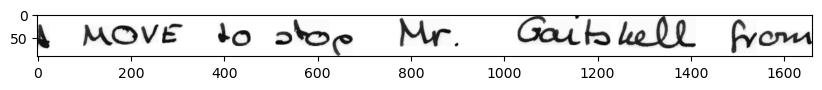

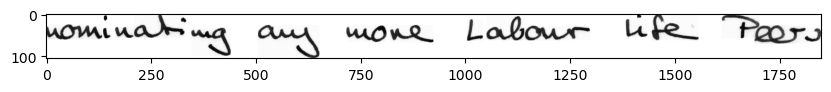

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

for file_name in img_files[:2]:
    img = mpimg.imread(file_name)
    plt.figure(figsize = (10,10))
    plt.imshow(img, cmap ='gray')

Encode writers with a value between 0 and ``n_classes-1``:

In [11]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoded_img_targets = encoder.fit_transform(img_targets)

print("Writer ID        : ", img_targets[:2])
print("Encoded writer ID: ", encoded_img_targets[:2])

Writer ID        :  ['000' '000']
Encoded writer ID:  [0 0]


Split dataset into train, validation, and tests sets:

In [12]:
from sklearn.model_selection import train_test_split

# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(img_files, encoded_img_targets, test_size=0.2, shuffle = True)

# Further split training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle = True)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(3141,) (786,) (982,)
(3141,) (786,) (982,)


Define a couple of constants that will be used throughout the model:

In [13]:
CROP_SIZE = 113
NUM_LABELS = 50
BATCH_SIZE = 16

As suggested in the paper, the input to the model are not unique sentences but rather random patches cropped from each sentence. The ``get_augmented_sample`` method is in charge of doing so by resizing each sentence's height to ``113`` pixels, and its width such that original aspect ratio is maintained. Finally, from the resized image, patches of ``113x113`` are randomly cropped.

In [14]:
from sklearn.utils import shuffle
from PIL import Image
import random

def get_augmented_sample(sample, label, sample_ratio):
    # Get current image details
    img = Image.open(sample)
    img_width = img.size[0]
    img_height = img.size[1]

    # Compute resize dimensions such that aspect ratio is maintained
    height_fac = CROP_SIZE / img_height
    size = (int(img_width * height_fac), CROP_SIZE)

    # Resize image 
    new_img = img.resize((size), Image.ANTIALIAS)
    new_img_width = new_img.size[0]
    new_img_height = new_img.size[1]

    # Generate a random number of crops of size 113x113 from the resized image
    x_coord = list(range(0, new_img_width - CROP_SIZE))
    num_crops = int(len(x_coord) * sample_ratio)
    random_x_coord = random.sample(x_coord, num_crops)
    
    # Create augmented images (cropped forms) and map them to a label (writer)
    images = []
    labels = []
    for x in random_x_coord:
        img_crop = new_img.crop((x, 0, x + CROP_SIZE, CROP_SIZE))
        # Transform image to an array of numbers
        images.append(np.asarray(img_crop))
        labels.append(label)

    return (images, labels)

Let's visualize what the ``get_augmented_sample`` method does by augmenting one sample from the training set. Let's first take a look at how the original image looks like:

Label:  16


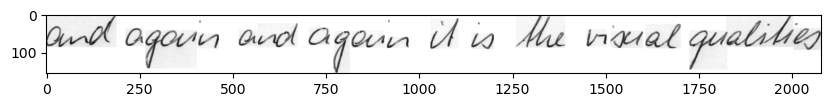

In [15]:
sample, label = X_train[0], y_train[0]
img = mpimg.imread(sample)
plt.figure(figsize = (10,10))
plt.imshow(img, cmap ='gray')
print("Label: ", label)

A now, let's augment it and see the result:

In [16]:
images, labels = get_augmented_sample(sample, label, 0.1)

C:\Users\User\AppData\Local\Temp\ipykernel_37420\3032259505.py:16: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  new_img = img.resize((size), Image.ANTIALIAS)


The ``labels`` returned by the ``get_augmented_sample`` is simply the label of the original image for each cropped patch:

In [17]:
print(labels)
print("Num of labels: ", len(labels))

[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]
Num of labels:  139


And the ``images`` returned by it are the random patches created from the original image (only two samples shown for simplicity):

139


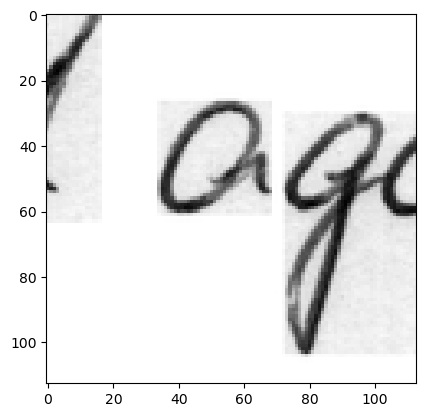

In [18]:
print(len(images))
plt.imshow(images[0], cmap ='gray')

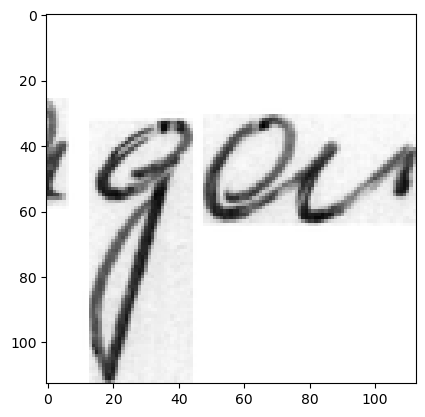

In [19]:
plt.imshow(images[1], cmap ='gray')

The model uses a generator in order to be able to call ``get_augmented_sample`` when training the model:

In [20]:
import operator
from functools import reduce
from keras.utils import to_categorical

def generate_data(samples, labels, batch_size, sample_ratio):
    while 1: 
        for offset in range(0, len(samples), batch_size):
            batch_samples = samples[offset:(offset + batch_size)]
            batch_labels = labels[offset:(offset + batch_size)]
            
            # Augment each sample in batch
            augmented_batch_samples = []
            augmented_batch_labels = []
            for i in range(len(batch_samples)):
                sample = batch_samples[i]
                label = batch_labels[i]
                augmented_samples, augmented_labels = get_augmented_sample(sample, label, sample_ratio)
                augmented_batch_samples.append(augmented_samples)
                augmented_batch_labels.append(augmented_labels)

            # Flatten out samples and labels
            augmented_batch_samples = reduce(operator.add, augmented_batch_samples)
            augmented_batch_labels = reduce(operator.add, augmented_batch_labels)
            
            # Reshape input format
            X_train = np.array(augmented_batch_samples)
            X_train = X_train.reshape(X_train.shape[0], CROP_SIZE, CROP_SIZE, 1)

            # Transform input to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            # Encode y
            y_train = np.array(augmented_batch_labels)
            y_train = to_categorical(y_train, NUM_LABELS)

            yield X_train, y_train

ModuleNotFoundError: No module named 'keras'

Create training, validation, and test generators:

In [ ]:
train_generator = generate_data(X_train, y_train, BATCH_SIZE, 0.3)
validation_generator = generate_data(X_val, y_val, BATCH_SIZE, 0.3)
test_generator = generate_data(X_test, y_test, BATCH_SIZE, 0.1)

In [ ]:
import tensorflow as tf

config = tf.ConfigProto()
tf.Session(config = config)

In [ ]:
def resize_image(img):
    size = round(CROP_SIZE/2)
    return tf.image.resize_images(img, [size, size])

The model used is exactly the same as the one in the "[handwriting_recognition](https://github.com/priya-dwivedi/Deep-Learning/tree/master/handwriting_recognition)" notebook by [Priyanka Dwivedi](https://github.com/priya-dwivedi):

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, Activation
from keras.layers.convolutional import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras.optimizers import Adam
from keras import metrics

model = Sequential()

# Define network input shape
model.add(ZeroPadding2D((1, 1), input_shape=(CROP_SIZE, CROP_SIZE, 1)))
# Resize images to allow for easy computation
model.add(Lambda(resize_image)) 

# CNN model - Building the model suggested in paper
model.add(Convolution2D(filters= 32, kernel_size =(5,5), strides= (2, 2), padding='same', name='conv1'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1'))

model.add(Convolution2D(filters= 64, kernel_size =(3, 3), strides= (1, 1), padding='same', name='conv2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2'))

model.add(Convolution2D(filters= 128, kernel_size =(3, 3), strides= (1, 1), padding='same', name='conv3'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool3'))


model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(NUM_LABELS, name='output'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['acc'])

print(model.summary())

Next, the model is trained for 20 epochs and the models obtained after each epoch are saved to the ``./model_checkpoints`` directory

In [ ]:
from keras.callbacks import ModelCheckpoint

# Create directory to save checkpoints at
model_checkpoints_path = "./model_checkpoints"
if not os.path.exists(model_checkpoints_path):
    os.makedirs(model_checkpoints_path)
    
# Save model after every epoch using checkpoints
create_checkpoint = ModelCheckpoint(
    filepath = "./model_checkpoints/check_{epoch:02d}_{val_loss:.4f}.hdf5",
    verbose = 1,
    save_best_only = False
)

# Fit model using generators
history_object = model.fit_generator(
    train_generator, 
    steps_per_epoch = round(len(X_train) / BATCH_SIZE),
    validation_data = validation_generator,
    validation_steps = round(len(X_val) / BATCH_SIZE),
    epochs = 20,
    verbose = 1,
    callbacks = [create_checkpoint]
)

Load a saved model weights and use them to predict labels in the test set:

In [ ]:
model_weights_path = "./model_checkpoints/model_weights.hdf5"
if model_weights_path:
    model.load_weights(model_weights_path)
    scores = model.evaluate_generator(test_generator, steps=round(len(X_test)/BATCH_SIZE))
    print("Accuracy: ", scores[1])
else:
    print("Set model weights file to load in the 'model_weights_path' variable")